## Import library

In [0]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [1]:
ls

adc.json  datalab@  drive/  sample_data/


In [2]:
cd drive/ptb_vae_lm

/content/drive/ptb_vae_lm


In [0]:
import tensorflow as tf
import numpy as np
import os
import re
import reader
from tensorflow.contrib.seq2seq import sequence_loss
import math
import matplotlib.pyplot as plt
import collections

!pip install -q mosestokenizer
from mosestokenizer import *
import copy

## Data Pre-processing

In [0]:
# def _read_words(filename):
#   with tf.gfile.GFile(filename, "r") as f: 
#     output = f.read().replace("\n", " eos ").replace(".", " .")
#     output = re.sub('[0-9]+', 'N', output)
#     return output
  
# def train_vocab_en(n):  
#     # get vocab in train which show more than n times
    
#     vocab = {'<PAD>': 0, '<OOV>': 1}
    
#     word_count = collections.defaultdict(float)
    
#     en_tokenize = MosesTokenizer('en')
    
#     for i in range(1):
#       data = _read_words("../ptb_data/ptb.train.txt")
#       data = en_tokenize(data)
    
#       for token in data:
#         word_count[token] += 1.0
                          
#     total_word = set(word_count)
    
#     for word in total_word:
#         if word_count[word] > n:
#             vocab[word] = len(vocab)  # word only show less than n times became oov
            
#     return vocab

In [0]:
# en_word_to_id = train_vocab_en(5) 
# en_word_to_id['<beg>'] = len(en_word_to_id)
# en_vocab_size = len(en_word_to_id)
# print(en_vocab_size)

In [0]:
# def _read_words(filename):
#   with tf.gfile.GFile(filename, "r") as f: 
#     output = f.read().replace("\n", " eos ").replace(".", " .")
#     output = re.sub('[0-9]+', 'N', output)
#     return output

# def _file_to_word_ids(data, word_to_id):
  
#   id_list = []
  
#   for word in data:
#     if word in word_to_id:
#       id_list.append(word_to_id[word])
#     else:
#       id_list.append(1)
          
#   return id_list

# def preprocess_train_data(pre_data, word_to_id, max_length):
#     pre_data_array = np.asarray(pre_data)
#     last_start = 0
#     data = []
#     each_sen_len = []
    
#     for i in range(len(pre_data_array)):
#         if pre_data_array[i]==word_to_id['eos']:
#             if max_length >= len(pre_data_array[last_start:(i+1)]):                
#               data.append(pre_data_array[last_start:(i+1)])
#               each_sen_len.append(i+1-last_start)
              
#             else:
#               shorten_sentences = pre_data_array[last_start:(last_start+max_length-1)]
#               shorten_sentences = np.concatenate((shorten_sentences, np.asarray([word_to_id['eos']])), axis=0)
#               data.append(shorten_sentences)
#               each_sen_len.append(max_length) 
            
#             last_start = i+1
            
#     out_sentences = np.full([len(data), max_length], word_to_id['<PAD>'], dtype=np.int32)
#     for i in range(len(data)):
#         out_sentences[i,:len(data[i])] = data[i]    
#     return out_sentences, np.asarray(each_sen_len)
            
#     return data, each_sen_len

In [0]:
# def generate_input_en(en_file, en_word_to_id, max_length):
  
#     en_data = _read_words(en_file)

#     en_tokenize = MosesTokenizer('en')

#     en_data = en_tokenize(en_data)

#     en_data_id = _file_to_word_ids(en_data, en_word_to_id)

#     en_input, en_input_len = preprocess_train_data(en_data_id, en_word_to_id, max_length)
    
#     return en_input, en_input_len
  
  
  
# def generate_decode_input_en(en_file, en_word_to_id, max_length):
    
#     en_data = _read_words(en_file)

#     en_tokenize = MosesTokenizer('en')

#     en_data = en_tokenize(en_data)

#     en_data_id = _file_to_word_ids(en_data, en_word_to_id)

#     en_output, en_output_len = preprocess_train_data(en_data_id, en_word_to_id, max_length)

#     out_beg_token = en_word_to_id['<beg>']*np.ones((en_output.shape[0], 1), dtype=np.int32)

#     en_output = np.concatenate((out_beg_token, en_output), axis=1)

#     return en_output,en_output_len

In [0]:
# def batch_producer(raw_data, raw_data_len, batch_size):    
#     data_len = len(raw_data)    
#     batch_len = data_len // batch_size    
#     data = np.reshape(raw_data[0 : batch_size * batch_len, :], [batch_size, batch_len, -1])
#     data = np.transpose(data, (1,0,2))
    
#     data_length = np.reshape(raw_data_len[0 : batch_size * batch_len], [batch_size, batch_len])
#     data_length = np.transpose(data_length, (1,0))
#     return data, data_length 

In [0]:
# oov_id = en_word_to_id['<OOV>']

# def dropout_func(decode_input, dropout_prob, oov_id=1):
#   for i in range(decode_input.shape[0]):
#     for j in range(decode_input.shape[1]):
#         for k in range(1,decode_input.shape[2]):
#             if np.random.uniform() > dropout_prob:
#                 decode_input[i,j,k] = oov_id
#   return decode_input

## Data processing

In [0]:
# def preprocess_train_data(pre_data):
#     pre_data_array = np.asarray(pre_data)
#     last_start = 0
#     max_length = 0
#     data = []
#     each_sen_len = []
    
#     for i in range(len(pre_data_array)):
#         if pre_data_array[i]==2:
#             data.append(pre_data_array[last_start:(i+1)])
#             each_sen_len.append(i+1-last_start) 
#             if max_length < len(pre_data_array[last_start:(i+1)]):
#                 max_length = len(pre_data_array[last_start:(i+1)])
#             last_start = i+1
            
#     out_sentences = np.full([len(data), max_length], word_to_id['<pad>'], dtype=np.int32)
#     for i in range(len(data)):
#         out_sentences[i,:len(data[i])] = data[i]    
#     return out_sentences, np.asarray(each_sen_len)
  
def preprocess_train_data(pre_data, word_to_id, max_length):
    pre_data_array = np.asarray(pre_data)
    last_start = 0
    data = []
    each_sen_len = []
    
    for i in range(len(pre_data_array)):
        if pre_data_array[i]==word_to_id['<eos>']:
            if max_length >= len(pre_data_array[last_start:(i+1)]):                
              data.append(pre_data_array[last_start:(i+1)])
              each_sen_len.append(i+1-last_start)
              
            else:
              shorten_sentences = pre_data_array[last_start:(last_start+max_length-1)]
              shorten_sentences = np.concatenate((shorten_sentences, np.asarray([word_to_id['<eos>']])), axis=0)
              data.append(shorten_sentences)
              each_sen_len.append(max_length) 
            
            last_start = i+1
            
    out_sentences = np.full([len(data), max_length], word_to_id['<pad>'], dtype=np.int32)
    for i in range(len(data)):
        out_sentences[i,:len(data[i])] = data[i]    
    return out_sentences, np.asarray(each_sen_len)
            
    return data, each_sen_len
  
  
# def preprocess_test_data(pre_data, max_length):
#     pre_data_array = np.asarray(pre_data)
#     last_start = 0
#     data = []
#     each_sen_len = []
    
#     for i in range(len(pre_data_array)):
#         if pre_data_array[i]==2:
#             data.append(pre_data_array[last_start:(i+1)])
#             each_sen_len.append(i+1-last_start)
#             last_start = i+1
            
#     out_sentences = np.full([len(data), max_length], word_to_id['<pad>'], dtype=np.int32)
#     for i in range(len(data)):
#         out_sentences[i,:len(data[i])] = data[i]

#     return out_sentences, np.asarray(each_sen_len)

  
  
def ptb_producer(raw_data, raw_data_len, batch_size):    
    data_len = len(raw_data)    
    batch_len = data_len // batch_size    
    data = np.reshape(raw_data[0 : batch_size * batch_len, :], [batch_size, batch_len, -1])
    data = np.transpose(data, (1,0,2))
    
    data_length = np.reshape(raw_data_len[0 : batch_size * batch_len], [batch_size, batch_len])
    data_length = np.transpose(data_length, (1,0))
    return data, data_length 

In [0]:
def dropout_func(decode_input, dropout_prob, oov_id):
  for i in range(decode_input.shape[0]):
    for j in range(decode_input.shape[1]):
        for k in range(1,decode_input.shape[2]):
            if np.random.uniform() > dropout_prob:
                decode_input[i,j,k] = oov_id
  return decode_input

In [6]:
train_data, valid_data, test_data, vocabulary, word_to_id = reader.ptb_raw_data(data_path="../ptb_data")
word_to_id['<pad>'] = 10000
word_to_id['<beg>'] = 10001
#word_to_id['<null>'] = 10002
len(word_to_id) 

10002

## Model

In [0]:
# set model parameter
vocab_len = len(word_to_id)

num_steps = 30
max_length = num_steps
batch_size = 50

batch_size = 1

embed_size = 300
hidden_size = 500
latent_size = 15

dropout_prob = 0.7

In [0]:
###################### define placeholder ######################
input_placeholder = tf.placeholder(tf.int32, [None, num_steps], 'input')                                # batch_size x num_steps
decode_placeholder = tf.placeholder(tf.int32, [None, num_steps+1], 'decode_input')                        # batch_size x num_steps

length_placeholder = tf.placeholder(tf.int32, [None, ], 'weight')                                       # batch_size x 1
dropout_placeholder = tf.placeholder(tf.float32, name='dropout') 

discount_placeholder = tf.placeholder(tf.float32, name='discount') 
learnrate_placeholder = tf.placeholder(tf.float32, name='learnrate') 

if_gene_placeholder = tf.placeholder(tf.bool, name='if_gene')
latent_var_placeholder = tf.placeholder(tf.float32, [batch_size, latent_size], 'la_var')       # batch_size x max_length x latent_size


#########################################################
xavier_initializer = tf.contrib.layers.xavier_initializer()


##################### embedding look-up for input sentences ######################

with tf.variable_scope('Embedding'):
    embedding = tf.get_variable('embeding',[vocab_len, embed_size], dtype=tf.float32, initializer=xavier_initializer)
    inputs = tf.nn.embedding_lookup(embedding, input_placeholder)                                       # batch_size x num_steps x embed_size
    inputs = tf.transpose(inputs, (1,0,2))                                                              # num_steps x batch_size x embed_size
    
    decode_in = tf.nn.embedding_lookup(embedding, decode_placeholder)
    decode_in = tf.transpose(decode_in, (1,0,2))
       
    
##################### encoder ######################
    
#### encoder lstm 
with tf.variable_scope('encode'):
    basic_cell = tf.contrib.rnn.BasicLSTMCell(hidden_size, forget_bias=0.0, state_is_tuple=True)
    init_state = basic_cell.zero_state(batch_size, tf.float32)
    outputs, state = tf.nn.dynamic_rnn(basic_cell, inputs, sequence_length=length_placeholder, initial_state=init_state, dtype=tf.float32, time_major=True)
    

In [0]:
#### the fully-connected layer to obatin the mean and variance of q(z/x) 
with tf.variable_scope('latent'):
    w_2_en = tf.get_variable('w2', [hidden_size, latent_size], dtype=tf.float32, initializer=xavier_initializer)
    b_2_en = tf.get_variable('b2', [latent_size,], dtype=tf.float32, initializer=xavier_initializer)
    w_3_en = tf.get_variable('w3', [hidden_size, latent_size], dtype=tf.float32, initializer=xavier_initializer)
    b_3_en = tf.get_variable('b3', [latent_size,], dtype=tf.float32, initializer=xavier_initializer)

In [0]:
#### generate sampled hidden code/latent variable 
final_hidden_state = state.h

#### hidden mean
mean_encode = tf.matmul(final_hidden_state,w_2_en) + b_2_en

#### hidden variance
log_var_encode = tf.matmul(final_hidden_state,w_3_en) + b_3_en
var_encode = tf.exp(log_var_encode)
std_encode = tf.sqrt(var_encode)

#### sample the latent variable z by reparameterization trick
eposida = tf.random_normal(tf.shape(std_encode), mean=0.0,stddev=1)
hidden_code = mean_encode + std_encode*eposida                                                          # batch_size x latent_size
      
    
#### KL Divergence loss  
#### could be calculated in closed form since both q(z/x) and p(z) are assumed to be Gaussian distribution

kl_div_loss = 1 + log_var_encode - tf.square(mean_encode) - var_encode     # batch_size x latent_size
kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, axis=1)                    # batch_size x 1

In [0]:
hidden_code = latent_var_placeholder

In [0]:
##################### decoder ######################

#### input for decoder lstm
stacked_hidden_code = []
for i in range(num_steps+1):
    stacked_hidden_code.append(hidden_code)
    
stacked_hidden_code = tf.stack(stacked_hidden_code, axis=0)         # num_steps x batch_size x latent_size

de_lstm_input = tf.concat([stacked_hidden_code, decode_in], 2)      # num_steps x batch_size x (embbedd_size + latent_size)

In [0]:
#### decoder lstm cell
with tf.variable_scope('decode'):
    de_basic_cell = tf.contrib.rnn.BasicLSTMCell(hidden_size, forget_bias=0.0, state_is_tuple=True)     
    de_init_state = de_basic_cell.zero_state(batch_size, tf.float32)
    de_outputs, de_state = tf.nn.dynamic_rnn(de_basic_cell, de_lstm_input, initial_state=de_init_state, dtype=tf.float32, time_major=True)


#### variablen of a FC layer to map the hidden state of the decoder-rnn in each time-step to the predicted next word
with tf.variable_scope('project'):
    U = tf.get_variable('rnn_output_w', [hidden_size,embed_size], dtype=tf.float32, initializer=xavier_initializer)
    proj_b = tf.get_variable('rnn_output_b', [embed_size,], dtype=tf.float32, initializer=xavier_initializer)

In [0]:
de_outputs_tran = tf.transpose(de_outputs,(1,0,2))

de_outputs_resh = tf.reshape(de_outputs_tran[:,:num_steps, :], [batch_size*num_steps, hidden_size])
  
logits = tf.matmul(de_outputs_resh, U) + proj_b

targets = tf.reshape(tf.transpose(inputs, (1,0,2)), [batch_size*num_steps, embed_size])

prob_unnorm = tf.exp(tf.reduce_sum(logits*targets, axis=1))

prob_constant = tf.exp(tf.matmul(logits, tf.transpose(embedding,(1,0))))

prob_norm = prob_unnorm/tf.reduce_sum(prob_constant, axis=1) 

log_prob_norm = tf.log(prob_norm)

log_prob_norm = tf.reshape(log_prob_norm, [batch_size, num_steps])

#### sequence weight
squence_weight = tf.sequence_mask(length_placeholder, maxlen=num_steps, dtype=tf.float32)

cross_entropy = - tf.reduce_sum(log_prob_norm*squence_weight, axis=1)


In [0]:
# # L2 reguralization for trainable variables
# train_variables = tf.trainable_variables()
# regularization_cost = tf.reduce_sum([tf.nn.l2_loss(variable) for variable in train_variables])
# regular_rate = 0.0002

In [0]:
batch_lowerbound = cross_entropy + discount_placeholder*kl_div_loss  # batch_size x 1

batch_lowerbound_mean = tf.reduce_mean(batch_lowerbound) 

objective = batch_lowerbound_mean 

#+ regular_rate*regularization_cost

#### optimizer
opt = tf.train.AdamOptimizer(learnrate_placeholder).minimize(batch_lowerbound_mean)

In [0]:
#### save the model
def save_model(session, path):
    if not os.path.exists("./result_0818/"):
        os.mkdir('./result_0818/')
    saver = tf.train.Saver()
    saver.save(session, path)

path1 = './result_0818/model_each_epch.ckpt'

In [0]:
def sigmoid(x):
    return (1 / (1 + math.exp(-x)))


def text_save(content,filename,mode='a'):
    # Try to save a list variable in txt file.
    file = open(filename,mode)
    for i in range(len(content)):
        file.write(str(content[i])+'\n')
    file.close()
    
def text_read(filename):
    # Try to read a txt file and return a list.Return [] if there was a mistake.
    try:
        file = open(filename,'r')
    except IOError:
        error = []
        return error
    content = file.readlines()
 
    for i in range(len(content)):
        content[i] = content[i][:len(content[i])-1]
 
    file.close()
    return content

## Train

In [0]:
train_input, train_sen_len = preprocess_train_data(train_data, word_to_id,max_length)

valid_input, valid_sen_len = preprocess_train_data(valid_data,word_to_id, max_length)

test_input, test_sen_len = preprocess_train_data(test_data,word_to_id,max_length)

In [0]:
train_beg_token = 10001*np.ones((train_input.shape[0],1), dtype=np.int32)
train_decode_input = np.concatenate((train_beg_token, train_input), axis=1)

train_input_data, train_len_data = ptb_producer(train_input, train_sen_len, batch_size)
train_decode_input_data, train_decode_len_data = ptb_producer(train_decode_input, train_sen_len, batch_size)
train_decode_input_data = dropout_func(train_decode_input_data, dropout_prob,word_to_id['<unk>'])

valid_beg_token = 10001*np.ones((valid_input.shape[0],1), dtype=np.int32)
valid_decode_input = np.concatenate((valid_beg_token, valid_input), axis=1)

valid_input_data, valid_len_data = ptb_producer(valid_input, valid_sen_len, batch_size)
valid_decode_input_data, valid_decode_len_data = ptb_producer(valid_decode_input, valid_sen_len, batch_size)
#valid_decode_input_data = dropout_func(valid_decode_input_data, dropout_prob,word_to_id['<unk>'])

test_beg_token = 10001*np.ones((test_input.shape[0],1), dtype=np.int32)
test_decode_input = np.concatenate((test_beg_token, test_input), axis=1)

test_input_data, test_len_data = ptb_producer(test_input, test_sen_len, batch_size)
test_decode_input_data, test_decode_len_data = ptb_producer(test_decode_input, test_sen_len, batch_size)
#test_decode_input_data = dropout_func(test_decode_input_data, dropout_prob,word_to_id['<unk>'])

In [0]:
record_index = np.random.randint(low=0, high=train_input.shape[0]-1, size=3000)
en_train_record = train_input[record_index]
en_de_train_record = train_decode_input[record_index]
en_train_len_record = train_sen_len[record_index]

en_train_record_data, en_train_len_record_data = ptb_producer(en_train_record, en_train_len_record, batch_size)
en_de_train_record_data, en_train_len_record_data = ptb_producer(en_de_train_record, en_train_len_record, batch_size)

In [0]:
train_ce = []
train_kl = []
train_ll = []
kl_weight = []

test_ce = []
test_kl = []
test_ll = []

init = tf.global_variables_initializer()
max_epochs = 10
learningrate = 0.001

total_step = 0
discount_rate = 0

with tf.Session() as sess:
  
    sess.run(init)
        
    for epoc in range(max_epochs):
      
        print('Epoch {}'.format(epoc))
              
        
        ########### training ###########
        for i in range(train_input_data.shape[0]):
            
            #discount_rate = sigmoid(0.0025*(total_step-2500))
            discount_rate = 0.0002*total_step
            if discount_rate >1:
              discount_rate = 1
              
            feed_dict = {input_placeholder: train_input_data[i],
                         decode_placeholder: train_decode_input_data[i],
                         length_placeholder: train_len_data[i],
                         discount_placeholder: discount_rate,
                         learnrate_placeholder: learningrate} 
            
            _ = sess.run(opt, feed_dict=feed_dict)
                    

            if total_step%100 == 0:
              
              train_ce_one = []
              train_kl_one = []
              train_ll_one = []
              for t in range(en_train_record_data.shape[0]):
                feed_dict = {input_placeholder: en_train_record_data[t],
                             decode_placeholder: en_de_train_record_data[t],
                             length_placeholder: en_train_len_record_data[t],
                             discount_placeholder: 1}
              
                ce, kl, ll_mean = sess.run([cross_entropy, kl_div_loss, batch_lowerbound_mean], feed_dict=feed_dict)
                train_ce_one.append(np.mean(ce))
                train_kl_one.append(np.mean(kl))
                train_ll_one.append(ll_mean)
             
              print("training")
              print(discount_rate)
              print(np.mean(ce))
              print(np.mean(kl))
              print(ll_mean)
             
              train_ce.append(np.mean(ce))
              train_kl.append(np.mean(kl))
              train_ll.append(ll_mean)
              kl_weight.append(discount_rate)
              
              
              test_ce_one = []
              test_kl_one = []
              test_ll_one = []
              for t in range(valid_input_data.shape[0]):
                test_feed_dict = {input_placeholder:  valid_input_data[t],
                                  decode_placeholder: valid_decode_input_data[t],
                                  length_placeholder: valid_len_data[t],
                                  discount_placeholder: 1}
                
                ce, kl, ll_mean = sess.run([cross_entropy, kl_div_loss, batch_lowerbound_mean], feed_dict=test_feed_dict)
              
                test_ce_one.append(np.mean(ce))
                test_kl_one.append(np.mean(kl))
                test_ll_one.append(ll_mean)
              
              print("testing")
              print(np.mean(test_ce_one))
              print(np.mean(test_kl_one))
              print(np.mean(test_ll_one))
              test_ce.append(np.mean(test_ce_one))
              test_kl.append(np.mean(test_kl_one))
              test_ll.append(np.mean(test_ll_one))
              
            total_step = total_step + 1             
                      
        save_model(sess, path1)
        
text_save(train_ce, './result_0818/train_ce.txt')
text_save(train_kl, './result_0818/train_kl.txt')
text_save(train_ll, './result_0818/train_ll.txt')
text_save(kl_weight,'./result_0818/kl_weight.txt')

text_save(test_ce, './result_0818/test_ce.txt')
text_save(test_kl, './result_0818/test_kl.txt')
text_save(test_ll, './result_0818/test_ll.txt')

## Train Result

Text(0.5,1,'encoder_2_DCNN_300_dropout_0.7')

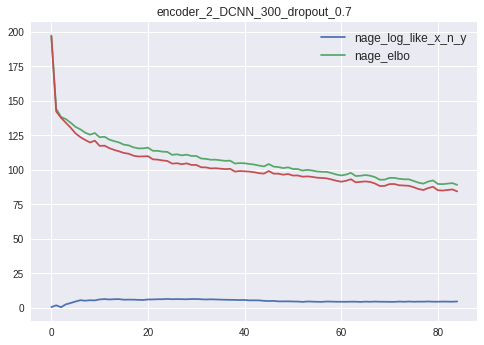

In [46]:
elbo_read = text_read('./result_0818/train_ce.txt')
elbo_read = [float(elbo) for elbo in elbo_read]

kl_read = text_read('./result_0818/train_kl.txt')
kl_read = [float(kl) for kl in kl_read]

likei_read = text_read('./result_0818/train_ll.txt')
likei_read = [float(likei) for likei in likei_read]

plt.plot(kl_read, color = 'C0')
plt.plot(likei_read, color = 'C1')
plt.plot(elbo_read, color = 'C2')
plt.legend(['nage_log_like_x_n_y', 'nage_elbo'], fontsize=12)
plt.title("encoder_2_DCNN_300_dropout_0.7")

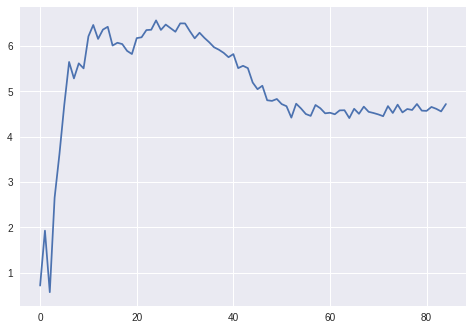

In [47]:
plt.plot(kl_read, color = 'C0')

## Generate Sentence from Prior

In [0]:
def id_to_word(words, word_to_id, max_length):
  sens = ["" for x in range(max_length+1)]
  for key in word_to_id.keys():
    for p in range(max_length):
      if words[p] == word_to_id[key]:
        sens[p] = key
  return sens

In [0]:
for i in range(beam_size):
  or_sens = id_to_word(x_de[i], word_to_id, decode_len+1)
  or_sens_str = " "
  for p in range(decode_len+1):
     or_sens_str = or_sens_str + " " + or_sens[p]
  print(or_sens_str)

In [59]:
########## Beam Search gene x ###########

beam_size = 30
conti = True
idd = 8
t = 0
latent_num = 1

import copy

#########################################################
x_len = np.array((1,30))

x_de = np.random.randint(low=0, high=vocab_len, size=(beam_size, max_length+1))
x_de[:,0] = word_to_id['<beg>']

x_de_new = np.zeros(x_de.shape, dtype=np.int32)

decode_len = 30

#########################################################
prob_next_word = np.ones((beam_size, vocab_len),dtype=np.float32)
score = np.zeros((beam_size))


#########################################################

with tf.Session() as sess:
  
    saver = tf.train.Saver()
    saver.restore(sess, path1)

    la_var = np.random.normal(size = (1,latent_size), loc=0.0, scale=1)
    
    for t in range(decode_len):
    #while conti:
      
        for j in range(beam_size):
          
          gene_feed_dict = {if_gene_placeholder: True,
                            latent_var_placeholder:la_var,
                            decode_placeholder: np.reshape(x_de[j],[1, num_steps+1])}
                                                                           
          prob_logits = sess.run(prob_constant, feed_dict=gene_feed_dict)
          
          prob_next_word[j] = np.log(prob_logits[t]/np.sum(prob_logits[t])) + score[j]
                
        beam_id = np.argmax(prob_next_word, axis=0)        
        prob_next_word_beam = np.max(prob_next_word, axis=0)        
        next_word_id = np.argsort(prob_next_word_beam)[-beam_size:]
        
        for j in range(beam_size):
          
          beam_id_j = beam_id[next_word_id[j]]
          word_id_j = next_word_id[j]
          
          x_de_new[j] = copy.deepcopy(x_de[beam_id_j])          
          x_de_new[j,t+1] = copy.deepcopy(word_id_j)
          
          score[j] = copy.deepcopy(prob_next_word_beam[word_id_j])
          
        
        x_de = copy.deepcopy(x_de_new)
       

INFO:tensorflow:Restoring parameters from ./result_0818/model_each_epch.ckpt


## Generate Sentence

In [0]:
def id_to_word(words, word_to_id, max_length):
  sens = ["" for x in range(max_length+1)]
  for key in word_to_id.keys():
    for p in range(max_length):
      if words[p] == word_to_id[key]:
        sens[p] = key
  return sens

In [0]:
origin_sens = id_to_word(train_input[8], word_to_id, max_length)
or_sens_str = " "
for p in range(max_length):
     or_sens_str = or_sens_str + " " + origin_sens[p]
print(or_sens_str)

In [0]:
for i in range(beam_size):
  or_sens = id_to_word(x_de[i], word_to_id, decode_len)
  or_sens_str = " "
  for p in range(decode_len):
     or_sens_str = or_sens_str + " " + or_sens[p]
  print(or_sens_str)

### Beam Search

In [41]:
########## Beam Search gene x ###########

beam_size = 25
conti = True
idd = 8
t = 0
latent_num = 1


#########################################################
x_in = np.reshape(copy.deepcopy(train_input[idd]), (1, max_length))
x_len = np.reshape(copy.deepcopy(train_sen_len[idd]), (1,))

x_de = np.random.randint(low=0, high=vocab_len, size=(beam_size, max_length+1))
x_de[:,0] = word_to_id['<beg>']

x_de_new = np.zeros(x_de.shape, dtype=np.int32)

decode_len = 30

#########################################################
prob_next_word = np.ones((beam_size, vocab_len),dtype=np.float32)
score = np.zeros((beam_size))


#########################################################

with tf.Session() as sess:
  
    saver = tf.train.Saver()
    saver.restore(sess, path1)

    gene_feed_dict = {input_placeholder: x_in, 
                      length_placeholder: x_len}                       
            
    mean, std = sess.run([mean_encode, std_encode], feed_dict=gene_feed_dict)    # 1*max_len x fr_vocab_size
    
    eposida = np.random.normal(size = np.shape(std), loc=0.0, scale=1)
    la_var = mean + std*eposida
    
    for t in range(decode_len):
    #while conti:
      
        for j in range(beam_size):
          
          gene_feed_dict = {if_gene_placeholder: True,
                            latent_var_placeholder:la_var,
                            decode_placeholder: np.reshape(x_de[j],[1, num_steps+1])}
                                                                           
          prob_logits = sess.run(prob_constant, feed_dict=gene_feed_dict)
          
          prob_next_word[j] = np.log(prob_logits[t]/np.sum(prob_logits[t])) + score[j]
                
        beam_id = np.argmax(prob_next_word, axis=0)        
        prob_next_word_beam = np.max(prob_next_word, axis=0)        
        next_word_id = np.argsort(prob_next_word_beam)[-beam_size:]
        
        for j in range(beam_size):
          
          beam_id_j = beam_id[next_word_id[j]]
          word_id_j = next_word_id[j]
          
          x_de_new[j] = copy.deepcopy(x_de[beam_id_j])          
          x_de_new[j,t+1] = copy.deepcopy(word_id_j)
          
          score[j] = copy.deepcopy(prob_next_word_beam[word_id_j])
          
        
        x_de = copy.deepcopy(x_de_new)
       

INFO:tensorflow:Restoring parameters from ./result_0816/model_saved/model_each_epch.ckpt
